In [259]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
from scipy.stats import linregress
import itertools

In [260]:

csv_path="frog_calls_clusters.csv"
data= pd.read_csv(csv_path)
frog_sequence = data['frog_id_kmm']
unique_frogs = sorted(frog_sequence.unique())
n_frogs = len(unique_frogs)
frog_coords=np.array([[125, 425], [425,375], [750,500],[725,375], [1000,375], [1100,575],[1300,400]])


In [261]:
def compute_transition_matrix(sequence, order=1):
    """
    Compute the transition probability matrix for a given sequence.

    Parameters:
        sequence (pd.Series): The sequence of frog calls.
        order (int): The order of the Markov model (1 for first-order, 2 for second-order).

    Returns:
        np.ndarray: The computed transition probability matrix."""
    if order == 1:
        transition_pairs,index_cols =compute_transition_matrix_for_first_order_markov(sequence)

        all_combinations = unique_frogs  # Ensure indexing consistency for first-order

    elif order == 2:
        transition_pairs,index_cols = compute_transition_matrix_for_second_order_markov(sequence)
        all_combinations= pd.MultiIndex.from_product([unique_frogs, unique_frogs]) #adding here another unqine frogs- 3 order markov

    else:
        raise ValueError("Unsupported order. Only 1st and 2nd order Markov models are supported.")

    # Compute transition counts
    transition_counts = pd.crosstab(index=[transition_pairs[col] for col in index_cols], columns=transition_pairs['next'])

    # Reindex to include all possible states
    transition_counts = transition_counts.reindex(index=all_combinations, columns=unique_frogs, fill_value=0)

    # Normalize to probabilities
    transition_probs = transition_counts.div(transition_counts.sum(axis=1), axis=0).fillna(0)

    return transition_probs.to_numpy()


In [262]:
def compute_transition_matrix_for_first_order_markov(frogs_sequence):
    """Compute the transition probability matrix for a given sequence."""
    current_frogs = frogs_sequence[:-1]
    next_frogs = frogs_sequence.shift(-1)[:-1]
    transition_pairs = pd.DataFrame({'current': current_frogs, 'next': next_frogs})
    index_col= ['current']

    return transition_pairs, index_col



In [263]:
def compute_transition_matrix_for_second_order_markov(frogs_seq):
    previous_frog1 = frogs_seq[:-2]
    previous_frog2 = frogs_seq.shift(-1)[:-2]
    next_frog= frogs_seq.shift(-2)[:-2]

    transition_pairs = pd.DataFrame({'previous_frog1': previous_frog1,  'previous_frog2':   previous_frog2, 'next': next_frog})
    index_cols = ['previous_frog1', 'previous_frog2']

    return transition_pairs, index_cols


In [264]:
def generate_shuffled_sequences(n_shuffles, markov_order=1):
    shuffled_matrices = []

    for i in range(n_shuffles):
        shuffled_sequence = frog_sequence.sample(frac=1).reset_index(drop=True)  # Shuffle
        shuffled_probs = compute_transition_matrix(shuffled_sequence, markov_order)
        shuffled_matrices.append(shuffled_probs)

    return np.array(shuffled_matrices)


In [265]:
first_order_observed_matrix = compute_transition_matrix(frog_sequence,order=1)
first_order_shuffled_matrix = generate_shuffled_sequences(n_shuffles=1000,markov_order=1)
first_order_mean_null = first_order_shuffled_matrix.mean( axis=0)
first_order_std_null = first_order_shuffled_matrix.std( axis=0)

In [266]:
second_order_observed_matrix = compute_transition_matrix(frog_sequence,order=2)
second_order_shuffled_matrix = generate_shuffled_sequences(n_shuffles=1000,markov_order=2)
second_order_mean_null = second_order_shuffled_matrix.mean( axis=0)
second_order_std_null = second_order_shuffled_matrix.std( axis=0)

In [267]:
def distance_vs_prob_diff(frog_coordinates,observed_matric,mean_null):

    distance_matrix = squareform(pdist(frog_coordinates,metric='euclidean'))
    probability_differences= np.abs(np.subtract(observed_matric, mean_null)) #organize the order of functions!!
    flat_distance_matrix= np.ravel(distance_matrix)
    flat_probability_differences= np.ravel(probability_differences)


    plt.figure(figsize=(12,7))
    plt.scatter(flat_distance_matrix,flat_probability_differences, label= 'Data Points',s= 10)
    coefficients = np.polyfit(flat_distance_matrix, flat_probability_differences, 1)
    trend_line = np.poly1d(coefficients)
    plt.plot(flat_distance_matrix, trend_line(flat_distance_matrix), color='red', label='Trend Line')
    correlation = np.corrcoef(flat_distance_matrix, flat_probability_differences)[0, 1]
    plt.xlabel('Physical Distance')
    plt.ylabel('Probability Difference')
    plt.title('Scatter Plot with Trend Line')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"correlation coefficient {correlation}")
    r_val_pearson, p_val_pearson=compute_pearson_correlation(flat_distance_matrix, flat_probability_differences)
    print(f"Pearson correlation: {r_val_pearson}")
    print(f"P-value: {p_val_pearson}")
    # plt.savefig('Scatter Plot with Trend Line first order',dpi=300,bbox_inches='tight')

In [268]:
def compute_pearson_correlation(X,Y):
    r, p_value = pearsonr(X, Y)
    return r, p_value


plotting distance between frogs vs first order probability differences

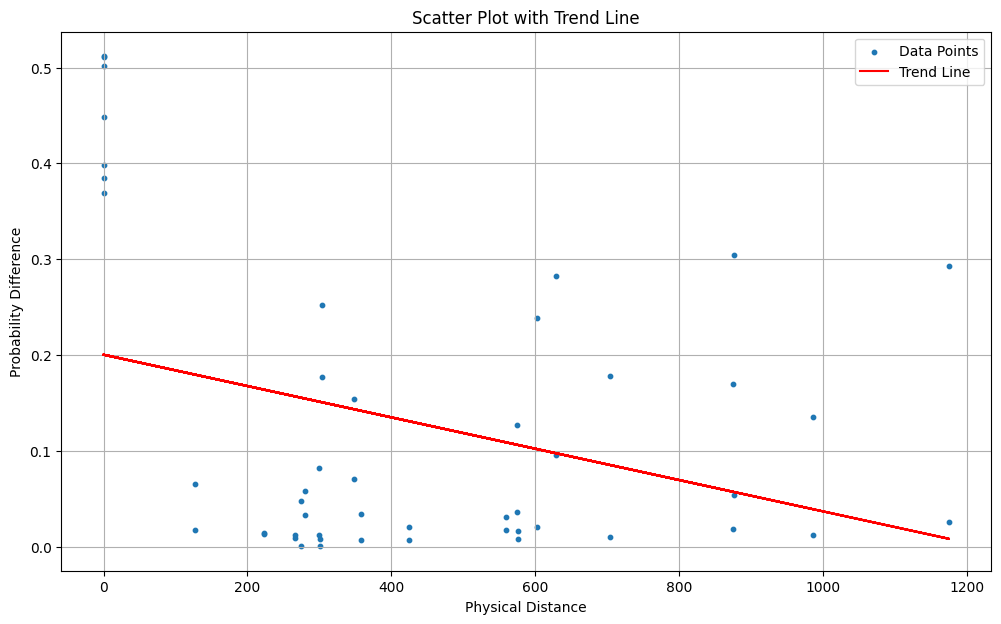

correlation coefficient -0.32812716331423153
Pearson correlation: -0.32812716331423153
P-value: 0.021350433410774857


In [269]:

distance_vs_prob_diff(frog_coords,first_order_observed_matrix,first_order_mean_null)

can't plot distance between frogs vs second order probability differences because the matrix size differ

In [286]:
def plot_dyads(mean_null, std_null, observed_matrix,threshold,title="Observed vs Null Transition Probabilities"):
    """
    Plots the observed probabilities against the null distribution for each dyad.

    Parameters:
        mean_null (numpy.ndarray): Mean of the null distribution.
        std_null (numpy.ndarray): Standard deviation of the null distribution.
        observed_matrix (numpy.ndarray): Observed transition probability matrix.
        title (str): Title of the plot.
    """
    # Step 1: Flatten the matrices to work with dyads as a list
    mean_null_flat = mean_null.flatten()
    std_null_flat = std_null.flatten()
    observed_probs_flat = observed_matrix.flatten()

    upper_threshold = mean_null_flat + threshold * std_null_flat
    lower_threshold = mean_null_flat - threshold * std_null_flat

    # Count significantly above and below cases
    significantly_above = np.sum(observed_probs_flat > upper_threshold)
    significantly_below = np.sum(observed_probs_flat < lower_threshold)
    total_significant = significantly_above + significantly_below
    total_comparisons = len(observed_probs_flat)  # Total number of dyads being compared

    # Print total comparisons
    print({f"significantly_above": significantly_above,
        "significantly_below": significantly_below,
        "total_significant": total_significant,
        "total_comparisons": total_comparisons
           })


    # Step 2: Sort dyads by the mean of the null distribution in descending order
    sorted_indices = np.argsort(mean_null_flat)[::-1]
    mean_null_sorted = mean_null_flat[sorted_indices]
    std_null_sorted = std_null_flat[sorted_indices]
    observed_probs_sorted = observed_probs_flat[sorted_indices]

    # Step 3: Determine the number of dyads
    n_dyads = len(mean_null_sorted)
    x = np.arange(n_dyads)  # Dyads on the x-axis

    # Step 4: Plot
    plt.figure(figsize=(24, 12))

    # Plot the null distribution (gray bars with error bars)
    plt.bar(x, 2 * std_null_sorted, bottom=mean_null_sorted - std_null_sorted,
            color='gray', alpha=0.5, label='Mean ± SD')

    # Plot the observed probabilities (red dots)
    plt.scatter(x, observed_probs_sorted, color='red', label='Observed Probabilities', zorder=3, s=5)

    # Labels and title
    plt.xlabel('Dyads (Pairs of Frogs)')
    plt.ylabel('Transition Probability')
    plt.title(title)
    plt.legend()
    plt.grid(True)

    # # Save the plot
    # filename = "Observed_vs_Null_Transition_Probabilities" if order == 1 else "Observed_vs_Null_Transition_Probabilities_Second_Order"
    # plt.savefig(f'{filename}.png', dpi=300, bbox_inches='tight')

    plt.show()  # Show the plot if needed


{'significantly_above': 7, 'significantly_below': 25, 'total_significant': 32, 'total_comparisons': 49}


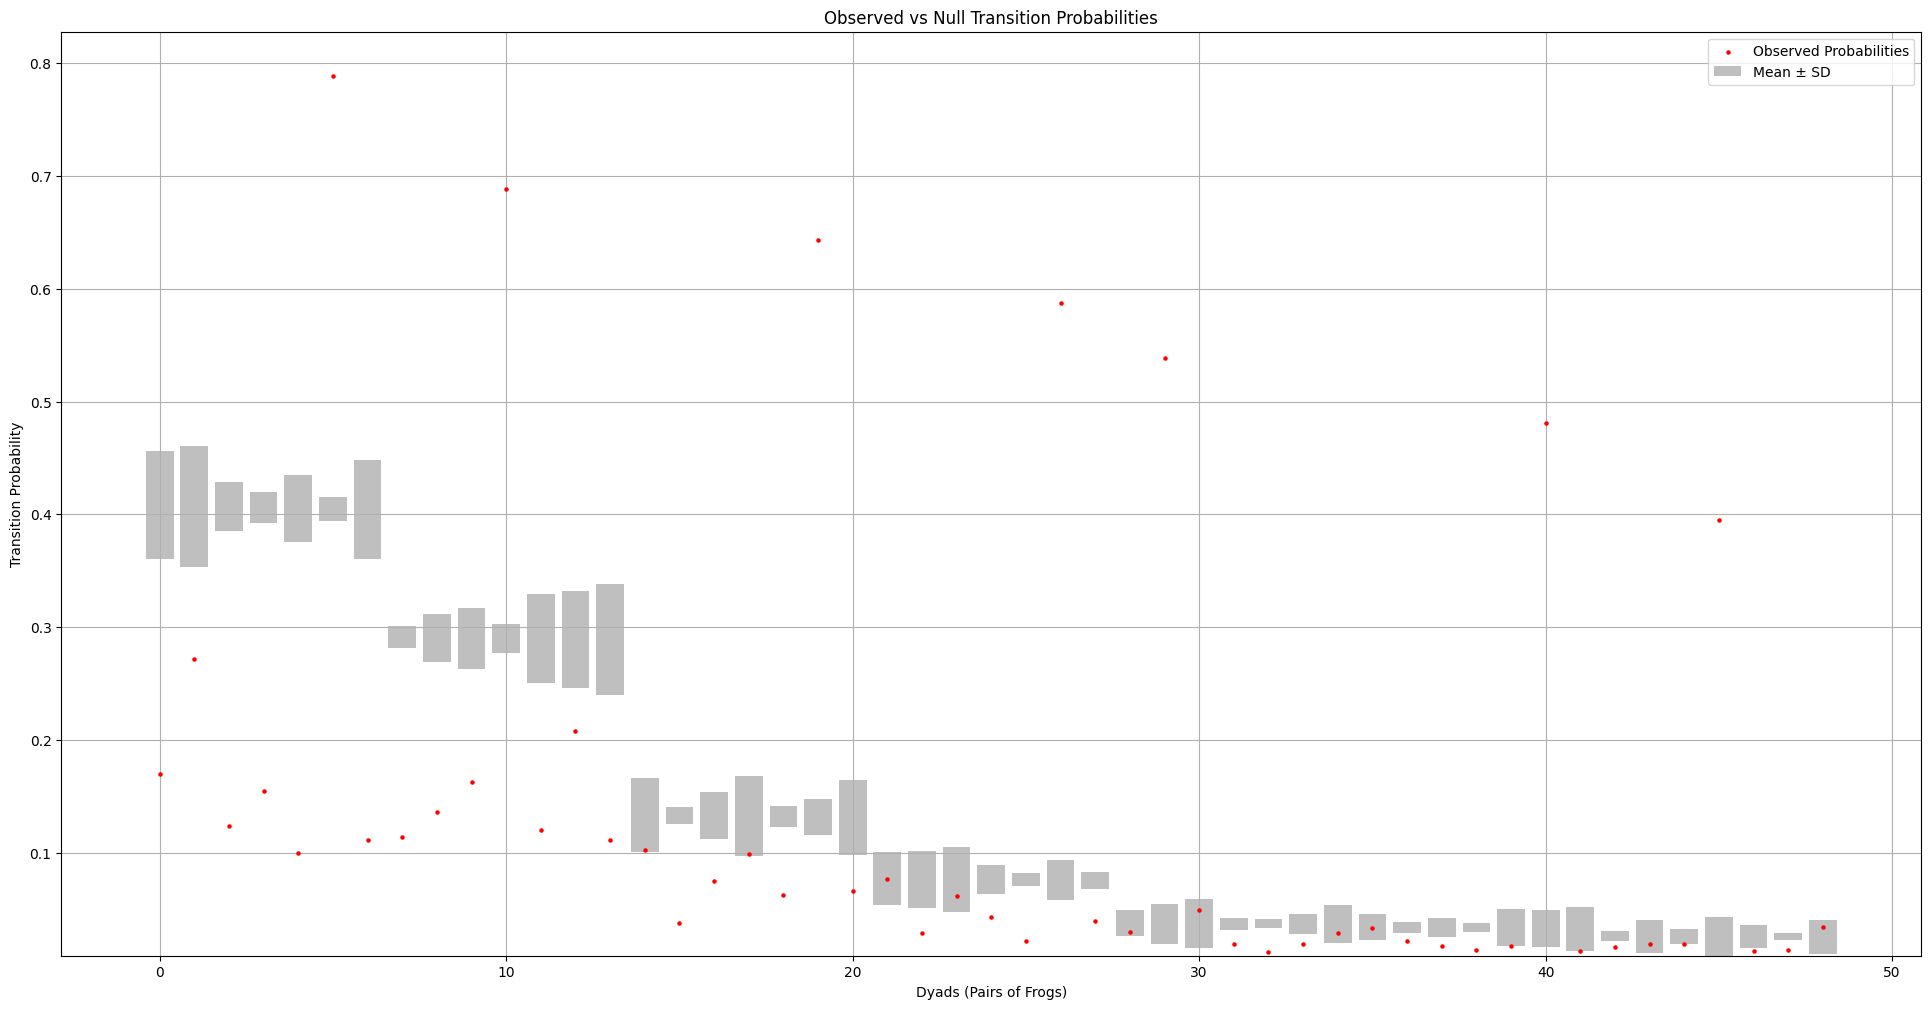

In [287]:
plot_dyads(first_order_mean_null,first_order_std_null,first_order_observed_matrix,2)


{'significantly_above': 58, 'significantly_below': 70, 'total_significant': 128, 'total_comparisons': 343}


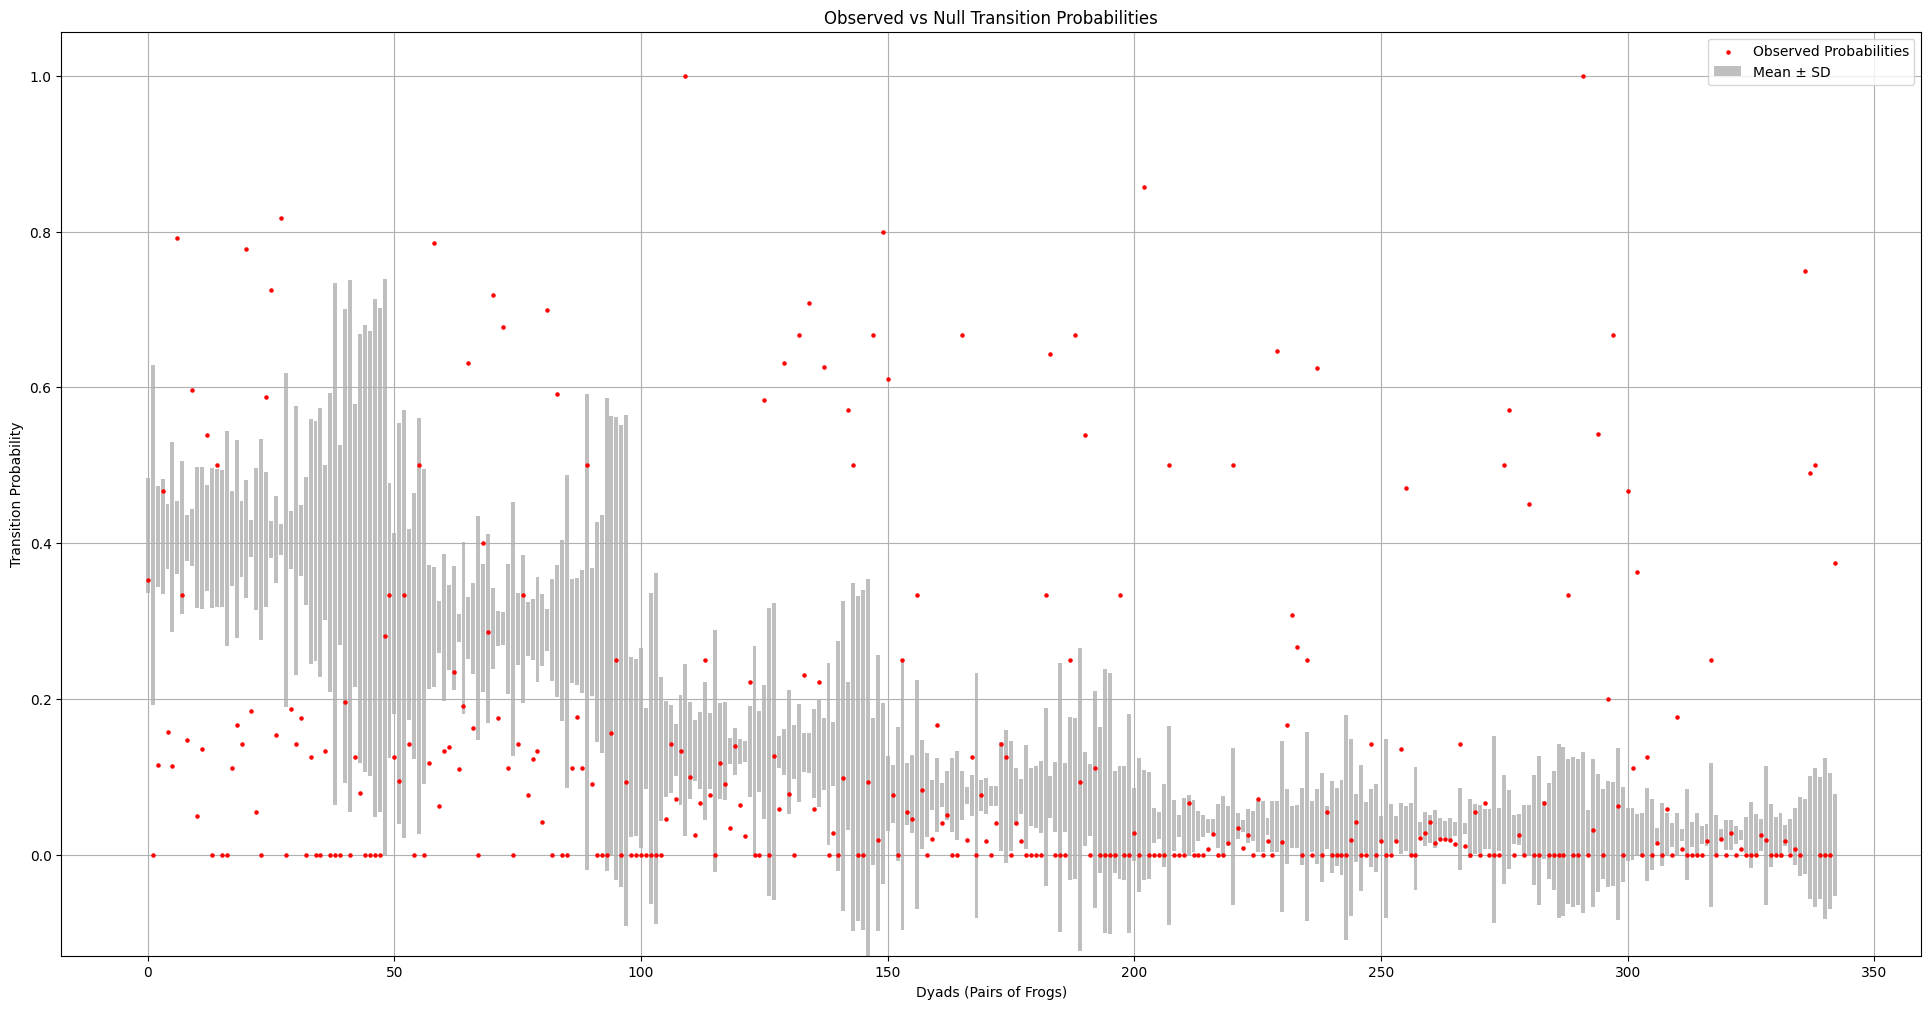

In [288]:
plot_dyads(second_order_mean_null,second_order_std_null,second_order_observed_matrix,2)

In [291]:
def correct_p_values_fdr(shuffled_transition_prop, data_transition_prop, n_shuffles, q):
    vals_grt_observed = np.divide(((shuffled_transition_prop >= data_transition_prop).sum(axis=0)), n_shuffles)
    vals_less_observed = np.divide(((shuffled_transition_prop < data_transition_prop).sum(axis=0)), n_shuffles)
    p_values = 2 * (np.minimum(vals_grt_observed, vals_less_observed))
    flatten_p_values = p_values.flatten()
    reject, pvals_corrected, _, _ = multipletests(flatten_p_values, alpha=q, method='fdr_bh')

    # Count how many remain statistically significant *after* FDR correction
    significant_after = np.sum(reject)

    # Print results
    print(f"Total comparisons: {len(reject)}")

    print(f"Statistically significant after FDR correction: {significant_after}")
    return reject, pvals_corrected


In [292]:

reject_for_first_order, pvals_corrected = correct_p_values_fdr(first_order_shuffled_matrix, first_order_observed_matrix, 1000, 0.05)


Total comparisons: 49
Statistically significant after FDR correction: 34


In [294]:
reject_for_second_order, pvals_corrected_for_second = correct_p_values_fdr(second_order_shuffled_matrix, second_order_observed_matrix, 1000, 0.05)


Total comparisons: 343
Statistically significant after FDR correction: 231


In [276]:
def check_null_distribution(matrix_from_shuffled): 
    for i in range(n_frogs):
        for j in range(n_frogs):
            all_data= matrix_from_shuffled[:,i,j]
            unique_probs,counts= np.unique(all_data,return_counts= True)
            plt.figure(figsize=(4, 3))
            plt.plot(unique_probs, counts, linestyle='-', color='blue', label=f'P({i} → {j})')
            plt.xlabel('Probability')
            plt.ylabel('Frequency')
            plt.title(f'Frequency Distribution for P({i} → {j})')
            plt.legend()
            plt.grid(True)
            plt.show()


In [277]:
def check_distribution(matrix_from_shuffled): #doesn't follow normal distribution!
    for i in range(n_frogs):
        for j in range(n_frogs):
            all_data= matrix_from_shuffled[:,i,j].tolist()

            stat,p = shapiro(all_data)
            print("p_ value", i,j ,"is", p)
            if p > 0.05:
                print("Data follows a normal distribution")
            else:
                print("Data does not follow a normal distribution")
    return 

In [278]:
def plot_null_distributions(shuffled_transition_prop,data_transition_prop,save_plots=False):
    lower_threshold= np.percentile(shuffled_transition_prop,5,axis=0)
    upper_threshold= np.percentile(shuffled_transition_prop,95,axis=0)
    non_significant_values = []
    for i in range(n_frogs):
        for j in range(n_frogs):
            observed_value= data_transition_prop[i,j]
            lower_val= lower_threshold[i,j]
            upper_val= upper_threshold[i,j]
          
            plt.figure(figsize=(4, 3))

            # Plot the histogram for P(i -> j)
            plt.hist(shuffled_transition_prop[:,i,j], bins=32, color='lightblue', alpha=0.7, label='Null Distribution')

            # Add thresholds and observed value
            plt.axvline(lower_val, color='red', linestyle='--', label='5% Lower Threshold')
            plt.axvline(upper_val, color='green', linestyle='--', label='95% Upper Threshold')
            plt.axvline(observed_value, color='blue', linestyle='-', label='Observed Value')

            # Add labels and legend
            plt.title(f'P({i} → {j})')
            plt.xlabel('Probability')
            plt.ylabel('Frequency')
            plt.legend()

            # Save or show the plot
            # if save_plots:
            #     filename = f'P({i}_to_{j}).png'
            #     plt.savefig(filename, dpi=300)
            #     print(f"Saved plot: {filename}")
            # else:
            plt.show()

            if not (observed_value <= lower_val or observed_value >= upper_val):
                non_significant_values.append((i, j, observed_value))

    print("Non-Significant Values (i, j, observed value):")
    for i, j, value in non_significant_values:
        print(f"({i}, {j}, {value:.4f})")

        
            
